In [3]:
import os, sys # os stands for "operating system" and includes read/write routines etc. 
import mkl
#mkl.set_num_threads(10)

import numpy as np # by far the most used library for everyday computation
from scipy import io # this is for importing Matlab data files
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter # here we import a single function
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our |plotting is done with plt
%matplotlib inline 
# %matplotlib notebook # if you need to zoom into a figure, this is the "interactive" mode of IPython
sys.path.insert(0, '/home/mano/Documents/Profesional Projects/Suite2p/suite2p/')

In [7]:
db = [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
db[0]['mname'], db[0]['datexp'], db[0]['blk'] = 'TX85', '2022_06_02', '2' 

In [9]:
iexp = 0 # which experiment to analyze
mname, datexp, blk = db[iexp]['mname'], db[iexp]['datexp'], db[iexp]['blk']
root = os.path.join('/run/user/1000/gvfs/smb-share:server=dm11.hhmi.org,share=pachitariulab/data/PROC/', mname, datexp, blk)
root

'/run/user/1000/gvfs/smb-share:server=dm11.hhmi.org,share=pachitariulab/data/PROC/TX85/2022_06_02/2'

In [10]:
fname     = 'Timeline_%s_%s_%s'%(mname, datexp, blk) # this is one of the ways to make a formatted string
fnamepath = os.path.join(root, fname) # from the "path" sublibrary of "os", we use the function "join"
Timeline  = io.loadmat(fnamepath, squeeze_me=True)['Timeline'] # here we combined two command "loadmat" with
# taking the "Timeline" field of the structure which loadmat returns. 

ops = np.load(os.path.join(root, 'suite2p', 'plane0', 'ops.npy'), allow_pickle=True).item() # ops is a "pickled" object,
# meaning it is not a simple numpy array. ".item()" is necessary because ops is a Python dictionary, not a numpy array.

# we initialize empty variables
spks = np.zeros((0, ops['nframes']), np.float32) # the neural data will be Nneurons by Nframes. 
stat = np.zeros((0,)) # these are the per-neuron stats returned by suite2p
xpos, ypos = np.zeros((0,)) , np.zeros((0,)) # these are the neurons' 2D coordinates


# this is for channels / 2-plane mesoscope
tlags = .25 + np.linspace(.2, -.8, ops['nplanes']//2+1)[:-1]
tlags = np.hstack((tlags, tlags))

print(tlags)

# loop over planes and concatenate
iplane = np.zeros((0,))

[ 0.45  0.35  0.25  0.15  0.05 -0.05 -0.15 -0.25 -0.35 -0.45  0.45  0.35
  0.25  0.15  0.05 -0.05 -0.15 -0.25 -0.35 -0.45]


In [12]:
from suite2p.extraction import dcnv
th_low, th_high = 0.5, 1.1
for n in range(ops['nplanes']):
    ops = np.load(os.path.join(root, 'suite2p', 'plane%d'%n, 'ops.npy'), allow_pickle=True).item()

    # load and deconvolve
    iscell = np.load(os.path.join(root, 'suite2p', 'plane%d'%n, 'iscell.npy'))[:,1]
    iscell = (iscell > th_low) * (iscell<th_high)
    
    stat0 = np.load(os.path.join(root, 'suite2p', 'plane%d'%n, 'stat.npy'), allow_pickle=True)[iscell]
    ypos0 = np.array([stat0[n]['med'][0] for n in range(len(stat0))]) # notice the python list comprehension [X(n) for n in range(N)]
    xpos0 = np.array([stat0[n]['med'][1] for n in range(len(stat0))]) 

    ypos0 += ops['dy'] # add the per plane offsets (dy,dx)
    xpos0 += ops['dx'] # add the per plane offsets (dy,dx)
    
    if 1:
        F0 = np.load(os.path.join(root, 'suite2p', 'plane%d'%n, 'F.npy'))[iscell]
        Fneu0 = np.load(os.path.join(root, 'suite2p', 'plane%d'%n, 'Fneu.npy'))[iscell]
        F0 = F0 - 0.7*Fneu0

        # compute spks0 with deconvolution
        x = np.arange(F0.shape[1])
        if tlags[n]<0:
            F0[:, 1:] = (1 + tlags[n]) * F0[:, 1:] + (- tlags[n]) * F0[:, :-1]
        else:
            F0[:, :-1] = (1 - tlags[n]) * F0[:, :-1] + tlags[n] * F0[:, 1:]

        F0 = dcnv.preprocess(F0.copy(), ops['baseline'], ops['win_baseline'], 
                                ops['sig_baseline'], ops['fs'], ops['prctile_baseline'])
        spks0 = dcnv.oasis(F0, ops['batch_size'], ops['tau'], ops['fs'])
    else:
        spks0 = np.load(os.path.join(root, 'suite2p', 'plane%d'%n, 'spks.npy'), allow_pickle=True)

    spks0 = spks0.astype('float32')
    iplane = np.concatenate((iplane, n*np.ones(len(stat0),)))
    stat = np.concatenate((stat,stat0), axis=0)     
    if spks.shape[1]>spks0.shape[0]:
        spks0 = np.concatenate((spks0, np.zeros((spks0.shape[0], spks.shape[1]-spks0.shape[1]), 'float32')), axis=1)
    spks = np.concatenate((spks,spks0), axis=0)            
    ypos = np.concatenate((ypos, ypos0), axis=0)
    xpos = np.concatenate((xpos, xpos0), axis=0)
    
    #zpos = np.concatenate((zpos, zpos0), axis=0)
    print('plane %d, '%n, 'neurons: %d'%len(xpos0))

print('total neurons %d'%len(spks))
    
xpos = xpos/ .75
ypos = ypos/ .5

plane 0,  neurons: 3858
plane 1,  neurons: 5775
plane 2,  neurons: 5651
plane 3,  neurons: 5138
plane 4,  neurons: 3082
plane 5,  neurons: 3088
plane 6,  neurons: 5118
plane 7,  neurons: 3528
plane 8,  neurons: 3443
plane 9,  neurons: 1605
plane 10,  neurons: 1706
plane 11,  neurons: 2242
plane 12,  neurons: 2143
plane 13,  neurons: 1961
plane 14,  neurons: 1548
plane 15,  neurons: 2027
plane 16,  neurons: 1974
plane 17,  neurons: 1812
plane 18,  neurons: 2005
plane 19,  neurons: 1301
total neurons 59005


Text(0, 0.5, 'Y position (um)')

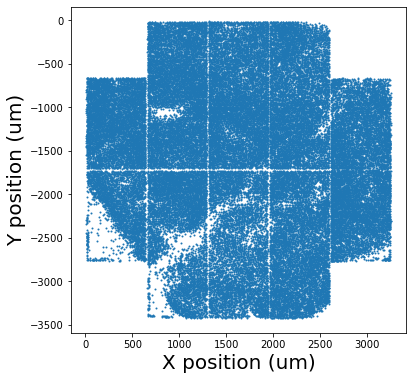

In [13]:
# POSITIONS OF ALL NEURONS
plt.figure(figsize=(6,6))
plt.scatter(xpos, -ypos, s = 1)
plt.xlabel('X position (um)', fontsize=20)
plt.ylabel('Y position (um)', fontsize=20)


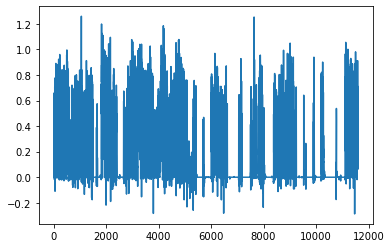

In [5]:
pframes = Timeline['packet'].item()
run = np.array([pframes[k]['roll'] for k in range(len(pframes))])
#pupil = np.array([pframes[k]['pup'] for k in range(len(pframes))])

plt.plot(run[1:,0])

In [14]:
NN, NT = spks.shape
tlag = 1 # this is the normal lag between frames and stimuli

frame_start = Timeline['stiminfo'].item()['frame_start']
istim = Timeline['stiminfo'].item()['istim']
nframes = len(frame_start)
frame_start = np.array(frame_start).astype('int')
frame_start0 = frame_start + tlag

ix = frame_start0<NT # limit to stimuli before recording ends
frame_start0 = frame_start0[ix]
sstim = istim[ix]

S = spks[:, frame_start0] # sample the neurons at the stimulus frames

In [25]:
np.unique(sstim)

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=object)

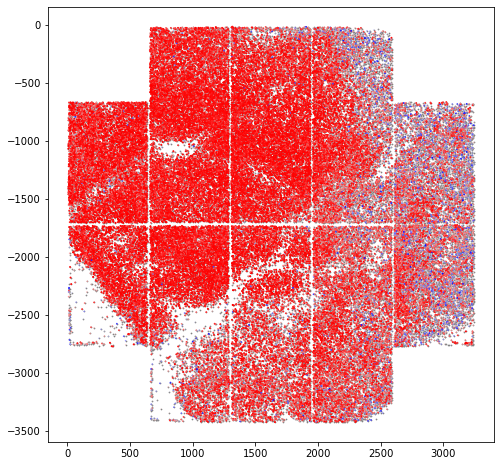

In [15]:
# this is just to see where the tuned neurons are
istim = np.unique(sstim)
k = 0
nstim = len(sstim)
ns = 8 #len(istim)
s2 = np.zeros((2, nstim, NN), 'float32')
for j in range(ns):
    ixx = (sstim==1+istim[j]) * (np.arange(nstim)<nstim) 
    ix = np.nonzero(ixx)[0]
    if len(ix)>=2:
        s2[0, k] = S[:, ix[0::2]].mean(-1)
        s2[1, k] = S[:, ix[1::2]].mean(-1)
        k +=1
s2 = s2[:,:k]

from scipy.stats import zscore
ss = s2 - np.mean(s2,1)[:,np.newaxis,:]
ss = ss / np.mean(ss**2,1)[:,np.newaxis,:]**.5

csig = (ss[0] * ss[1]).mean(0)
csig.mean()

plt.figure(figsize=(8,8))
plt.scatter(xpos, -ypos, c = 'gray', s = .5)
plt.scatter(xpos, -ypos, c = csig, s = csig**2, cmap = 'bwr', vmax = 1, vmin=-1)

In [16]:
_, nc = np.unique(sstim, return_counts = True)
nc

array([668, 668, 668, 668, 668, 668, 668, 668])

In [17]:
nreps = np.min(nc[:8])
Ssub = np.zeros((8,NN,nreps))

for k in range(8):
    ii = (sstim==(1+k)).nonzero()[0][:nreps]
    Ssub[k] = S[:, ii]

In [18]:
# compute d-prime from even trials only
mu = Ssub[:, :,::2].mean(-1)
sd = Ssub[:, :,::2].std(-1)

dp = 2 * (mu[:4] - mu[4:])/(sd[:4] + sd[4:])

1633 neurons above d-prime = 0.5


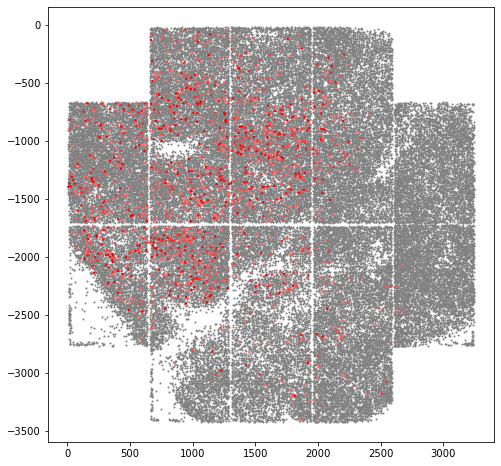

In [19]:
ix = (dp[0]>.5)
print('%d neurons above d-prime = 0.5'%ix.sum())

plt.figure(figsize=(8,8))
plt.scatter(xpos, -ypos, c = 'gray', s = 1)
plt.scatter(xpos[ix], -ypos[ix], c = dp[0,ix], cmap = 'bwr', vmax = 1, vmin=-1, s = 2);
# points colored in red are above the 0.5 dprime

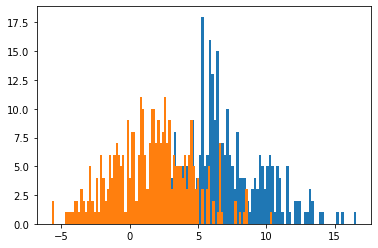

In [20]:
cth = 0.5 # threshold on d-prime to select neurons
kk = 0 # training image is 0
ix1 = (dp[kk]>cth) * (iplane<10) #the last ten ROIs are in the top plane
ix2 = (-dp[kk]>cth)* (iplane<10)

# spop is the decoder applied to test trials
spop = (Ssub[:,ix1,1::2].mean(1) - Ssub[:,ix2,1::2].mean(1))

plt.hist(spop[2], 100);
plt.hist(spop[6], 100);

Text(0, 0.5, 'decoder average response')

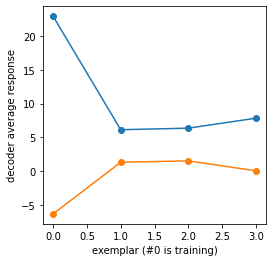

In [21]:
# this is the main figure: the goal is to have test images (1,2,3) be well separated by this decoder. 
# comparison is to the train image (0). 

plt.figure(figsize=(4,4))
plt.plot(np.mean(spop, -1).reshape((2, 4)).T, '-o')
plt.xlabel('exemplar (#0 is training)')
plt.ylabel('decoder average response')


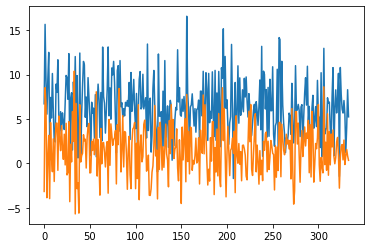

In [22]:
# trial by trial response of the decoder
plt.plot(spop[2])
plt.plot(spop[6])

In [15]:
#outfile = 'H:/PROJECTS/generalization/TX85_oneshot.npz'
#np.savez(outfile, S = Ssub, xpos = xpos, ypos = ypos, iplane = iplane)#, rf = rf)